Original tutorial links:
https://www.kaggle.com/mishki/twitter-sentiment-analysis-using-nlp-techniques

https://www.kaggle.com/ryanliwag1twitter-analysis-on-the-us-election-2020-finale

https://www.kaggle.com/maksymshkliarevskyi/us-election-eda-sentiment-analysis



CODE is based on the authors above with some minor tweaks

# Configuring enivronment and confirming environment

In [ ]:
#
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials


# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
print(sys.executable)

import sys
!{sys.executable} -m pip --version

/usr/bin/python3
pip 19.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


# Importing libraries

In [ ]:
# Importing for numerical computation (numpy) and data processing & manipulation (panadas)
import numpy as np
import pandas as pd

# Importing for data visualization
import matplotlib.pyplot as plt # basic data visualization
from matplotlib import rcParams # nicer data visualization variant
import seaborn as sns # nicer data visualization

# for timing code execution
import time

#Loading NLP [Natural Language Processing] Libraries
import nltk  
from nltk.tokenize import word_tokenize #tokenizer - takes sentences and transforms them into words e.g. from: [I like coding] to: ['I'] ['like'] ['coding']
from nltk.stem import PorterStemmer # to stem words - e.g. transforms the word: abatement to: abat
from nltk.corpus import stopwords #stopwords such as " "
from nltk.sentiment.vader import SentimentIntensityAnalyzer #pre-trained sentiment analyzer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet



nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

import re # REGEX (regular expressions)

!pip install gensim
import gensim
from gensim.parsing.preprocessing import remove_stopwords # we also use gensim for stopwords removal

from textblob import TextBlob #pre-trained sentiment analyzer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Dataset

In [ ]:
# Loading both twitter datasets
df_don = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/hashtag_donaldtrump.csv', lineterminator='\n')
df_joe = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/hashtag_joebiden.csv', lineterminator='\n')

# Quick stats dtypes and size, and countries

In [ ]:
print('Total number of records in Donald Trump dataset: ', df_don.shape)
print('Total number of records in Joe Biden dataset: ', df_joe.shape)

Total number of records in Donald Trump dataset:  (970919, 21)
Total number of records in Joe Biden dataset:  (776886, 21)


In [ ]:
# Both datasets have the same columns and types; used [df_joe.dtypes] to check, left out to save space
df_don.dtypes

created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
source                   object
user_id                 float64
user_name                object
user_screen_name         object
user_description         object
user_join_date           object
user_followers_count    float64
user_location            object
lat                     float64
long                    float64
city                     object
country                  object
continent                object
state                    object
state_code               object
collected_at             object
dtype: object

In [ ]:
#checking all unique countries Trump
df_don.country.unique()

In [ ]:
#checking all unique countries Biden
df_joe.country.unique()

# Summary stats of initial dataset and vizualizations

In [ ]:
# Combine both datasets into a single Dataframe, while adding a column to then filter the data on
df_don['hashtag'] = 'Trump'
df_joe['hashtag'] = 'Biden'
df_jd_concat = pd.concat([df_don, df_joe])

# Convert column from object to datatime format
df_jd_concat['created_at'] = pd.to_datetime(df_jd_concat.created_at)

In [ ]:
df_jd_concat.created_at.dtype

dtype('<M8[ns]')

In [ ]:
df_jd_concat.head(10)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
5,2020-10-15 00:00:17,1.316529e+18,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,2013-02-01 01:37:38,2363.0,"Perris,California",33.782519,-117.228648,NaN,United States of America,North America,California,CA,2020-10-21 00:00:01.866082651,Trump
6,2020-10-15 00:00:17,1.316529e+18,@richardmarx Glad u got out of the house! DICK...,0.0,0.0,Twitter for iPhone,7.674018e+17,Michael Wilson,wilsonfire9,NaN,2016-08-21 16:43:51,75.0,"Powell, TN",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:02.239299182,Trump
7,2020-10-15 00:00:18,1.316529e+18,@DeeviousDenise @realDonaldTrump @nypost There...,0.0,0.0,Twitter for iPhone,9.007611e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,sm_gulledge,"Patriot, Wife, “Shaken not Stirred” Mom of two...",2017-08-24 16:45:49,766.0,"Ohio, USA",40.225357,-82.688140,NaN,United States of America,North America,Ohio,OH,2020-10-21 00:00:02.612515712,Trump
8,2020-10-15 00:00:20,1.316529e+18,One of the single most effective remedies to e...,0.0,0.0,Twitter Web App,5.404769e+08,Jamieo,jamieo33,"Don't know what I am. Can lean left and right,...",2012-03-30 00:30:54,151.0,"Pennsylvania, USA",40.969989,-77.727883,NaN,United States of America,North America,Pennsylvania,PA,2020-10-21 00:00:02.985732243,Trump
9,2020-10-15 00:00:21,1.316529e+18,#Election2020 #Trump \n#FreedomOfSpeech https:...,0.0,0.0,Twitter Web App,1.305533e+18,Johnny Quest,JohnnyQuest22,Independent\n\nWhat is your American Dream?\nT...,2020-09-14 15:45:18,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:03.358948773,Trump


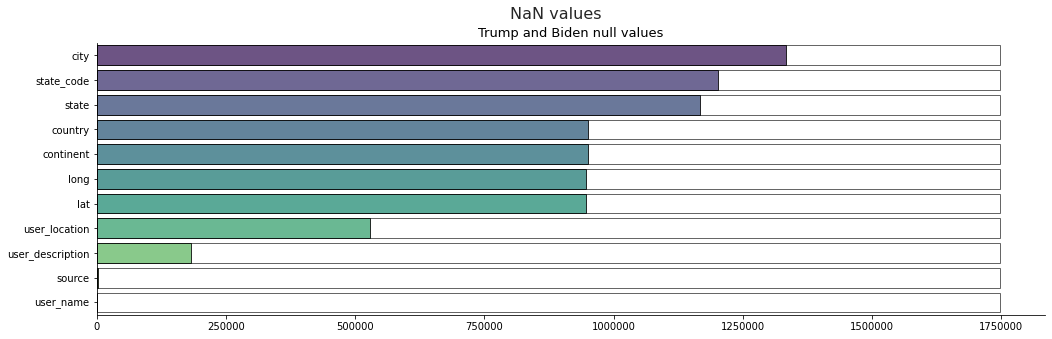

In [ ]:
# Creating a figure to display the NAN values
# Something to keep in mind for later when doing State analysis - when the country colmun is needed

dataset_nan = pd.Series(df_jd_concat.isna().sum()[df_jd_concat.isna().sum() > 0].
                      sort_values(ascending = False))
                      
fig, (ax1) = plt.subplots(1, figsize=(17, 5))
sns.set_style("whitegrid")
fig.suptitle('NaN values', size = 16)

sns.barplot(y = dataset_nan.index, x = [len(df_jd_concat)] * len(dataset_nan),
            edgecolor = 'black', color = 'white', alpha = 0.6, ax = ax1)
sns.barplot(y = dataset_nan.index, x = dataset_nan, 
            edgecolor = 'black', alpha = 0.8, ax = ax1,
            palette = sns.color_palette("viridis", len(dataset_nan)))
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.set_title('Trump and Biden null values', size = 13)


sns.despine()

In [ ]:
# Modules/Libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

# adjusting the column width by setting the style with seaborn
rcParams['figure.figsize'] = 20.7,8.27 
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
#Checking for duplicates
print('Number of duplicates: {}'.format(df_jd_concat.duplicated(subset=['tweet_id']).sum()))

Number of duplicates: 224896


In [ ]:
#Dropping Duplicates
print('Total size of Combined Dataframe',df_jd_concat.shape)
df_jd_concat.drop_duplicates(subset=['tweet_id'], keep=False, inplace=True)
print('Total size without duplicates',df_jd_concat.shape)

Total size of Combined Dataframe (1747805, 22)
Total size without duplicates (1299223, 22)


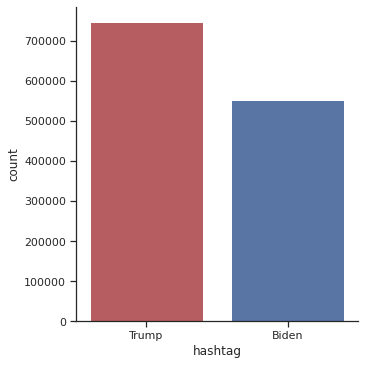

In [ ]:
# Total Tweet mentions or hashtags for each candidate
graph = sns.set_theme(style='ticks')
graph = sns.catplot(x='hashtag', y='count', kind='bar', palette=['r', 'b'],
           data=pd.DataFrame(df_jd_concat[['hashtag']].value_counts()).reset_index().rename(columns={0:'count'}))

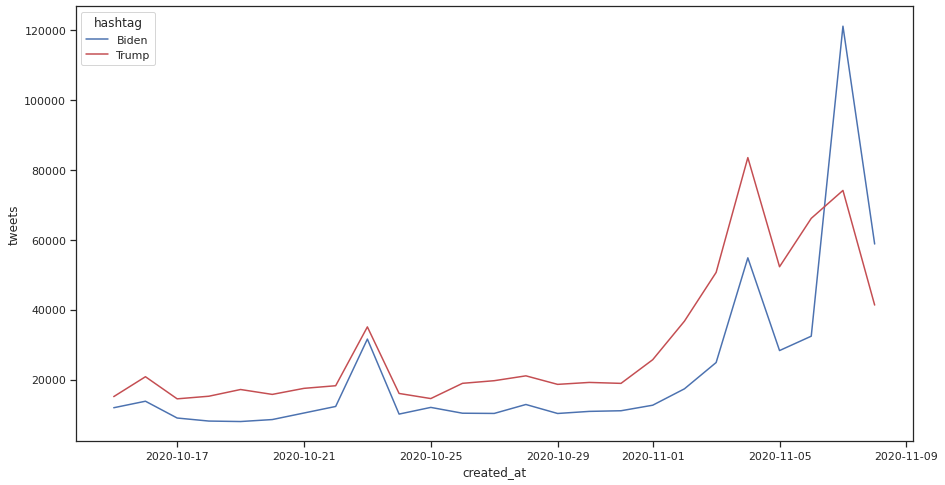

In [ ]:
#Tweet Frequency Over Time All Countries

rcParams['figure.figsize'] = 15,8

tweets = df_jd_concat.resample('D', on='created_at')['hashtag'].value_counts().unstack(1)

tweets.reset_index(inplace=True)

tweets = tweets.melt('created_at', var_name='hashtag',  value_name='tweets')

sns.set_style('ticks')
sns.lineplot(x='created_at', y='tweets', hue='hashtag', data=tweets, palette=['b', 'r'])

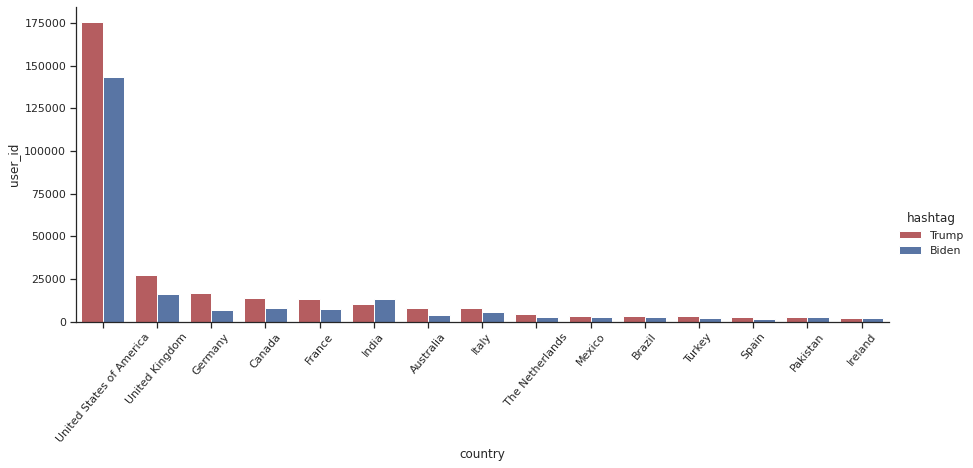

In [ ]:
# Top 15 Countries Tweeting about Trump and Biden
rcParams['figure.figsize'] = 30,20

df_jd_concat['country'] = df_jd_concat['country'].replace({'United States':'United States of America'})
data = df_jd_concat[(df_jd_concat.country.isin
                     (df_jd_concat.country.value_counts()[:15].index))].groupby(['country', 'hashtag']).count().sort_values(by=['user_id'], ascending=False)['user_id'].reset_index()


ax=sns.catplot(x='country', y='user_id', hue='hashtag', kind='bar', aspect=20.5/8.27,palette=['r', 'b'], data=data)
ax.set_xticklabels(rotation=50)

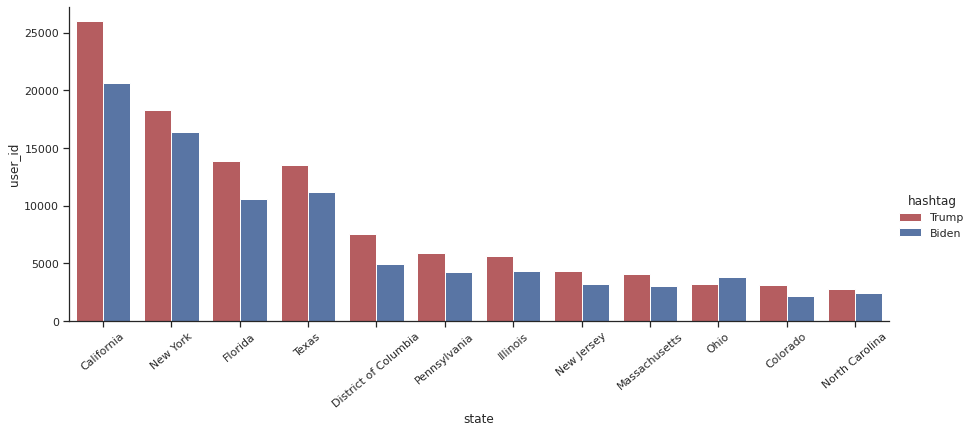

In [ ]:
#Top 15 States Tweeting about Trump and Biden

ax=sns.catplot(x='state', y='user_id', hue='hashtag', kind='bar', aspect=20.5/8.27, palette=['r', 'b'],
              data = df_jd_concat[(df_jd_concat.country == 'United States of America') & 
                  (df_jd_concat.state.isin(df_jd_concat.state.value_counts()[:15].index))]
                  .groupby(['state', 'hashtag'])
                  .count()
                  .sort_values(by=['user_id'], ascending=False)['user_id']
                  .reset_index())
ax.set_xticklabels(rotation=40)

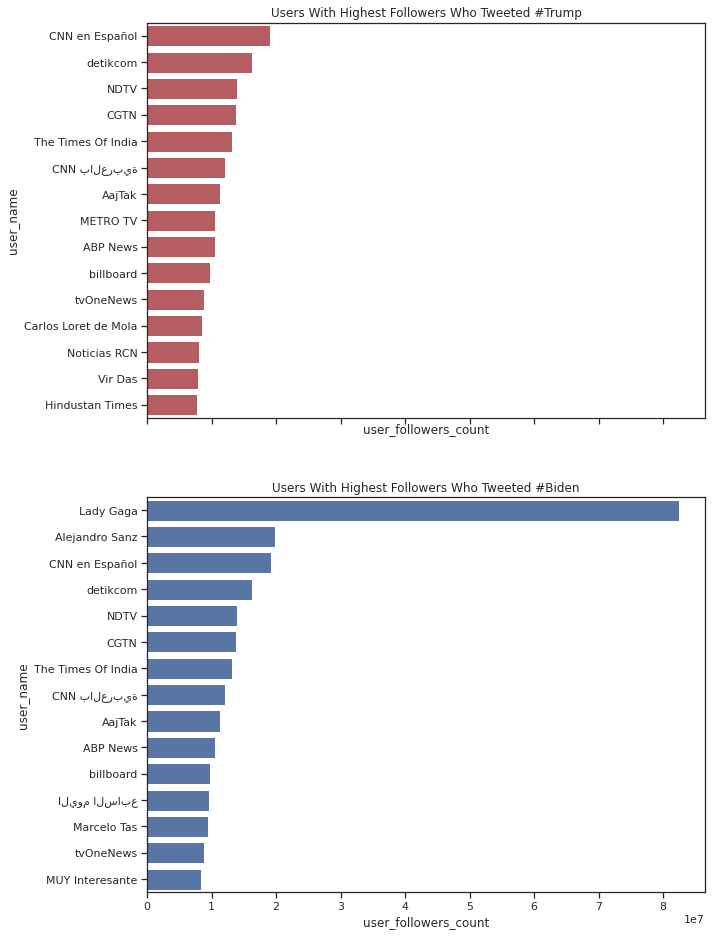

In [ ]:
# Top 15 Users with the Highest Follower Count Tweeting about Trump and Biden
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 16), sharex=True)
sns.barplot(x='user_followers_count', y='user_name', orient='h', ax=ax1, palette=['r'],
           data=df_jd_concat[(df_jd_concat.hashtag == 'Trump')]
           .drop_duplicates(subset=['user_name'])
           .sort_values(by=['user_followers_count'], ascending=False)[['user_name', 'user_followers_count']][:15])
ax1.set_title('Users With Highest Followers Who Tweeted #Trump')

sns.barplot(x='user_followers_count', y='user_name', orient='h', ax=ax2, palette=['b'],
           data=df_jd_concat[(df_jd_concat.hashtag == 'Biden')]
           .drop_duplicates(subset=['user_name'])
           .sort_values(by=['user_followers_count'], ascending=False)[['user_name', 'user_followers_count']][:15])
ax2.set_title('Users With Highest Followers Who Tweeted #Biden')
fig.show()

In [ ]:
# Helper functions - that will be recalled later

# creating a function to strip the hashtags from the words and creating a list of them

def get_hashtags(df_jd_concat):
    df_jd_concat["all_hashtags"] = df_jd_concat.tweet.apply(lambda x: ",".join([tag.strip("#") for tag in x.split() if tag.startswith("#")]))
    allhashtags = ",".join(df_jd_concat["all_hashtags"].values.tolist()).split(",")
    allhashtags = [i.upper() for i in allhashtags if i != ""]
    
    return allhashtags

# creating a wordcloud function that; importing a custom font

def wordcloud_create(text, color_func, max_words=100, font_path='/content/drive/MyDrive/CIND_820/Data/goodtime.ttf'):
    
    wordcloud = WordCloud(width=2560, 
                          height=800,
                          max_font_size=200, 
                          max_words=max_words, 
                          background_color="white",
                          collocations=False,
                          color_func=color_func,
                          font_path=font_path).generate(text)
    
    plt.figure(figsize=(29,9))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#Creating functions for the different colour schemes

def random_red_colour (word=None, *args, **kwargs):
    h = int(11)
    s = 100
    l = int(float(random.randint(30, 65)))

    return "hsl({}, {}%, {}%)".format(h, s, l)

def random_blue_colour (word=None, *args, **kwargs):
    h = int(245)
    s = 100
    l = int(float(random.randint(20, 65)))

    return "hsl({}, {}%, {}%)".format(h, s, l)

In [ ]:
allhashtags = get_hashtags(df_jd_concat) #creates a list of all the hashtags (text that starts with #)

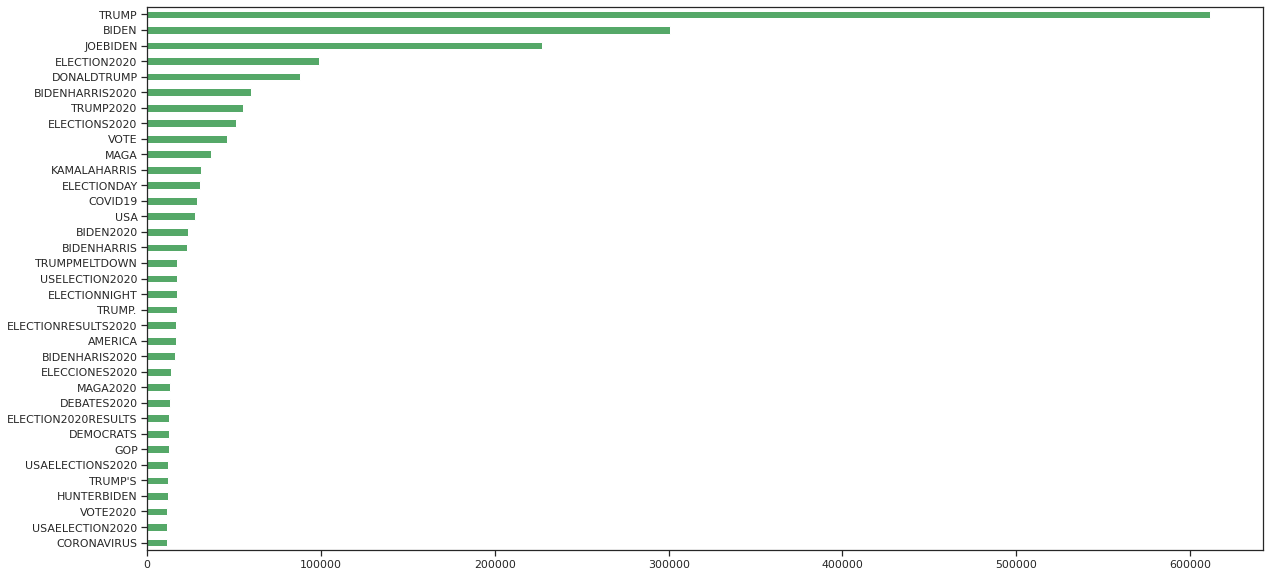

In [ ]:
# 35 Most Popular Hashtags
rcParams['figure.figsize'] = 20,10
pd.Series(allhashtags).value_counts()[:35].sort_values(ascending=True).plot(kind='barh', color='g')

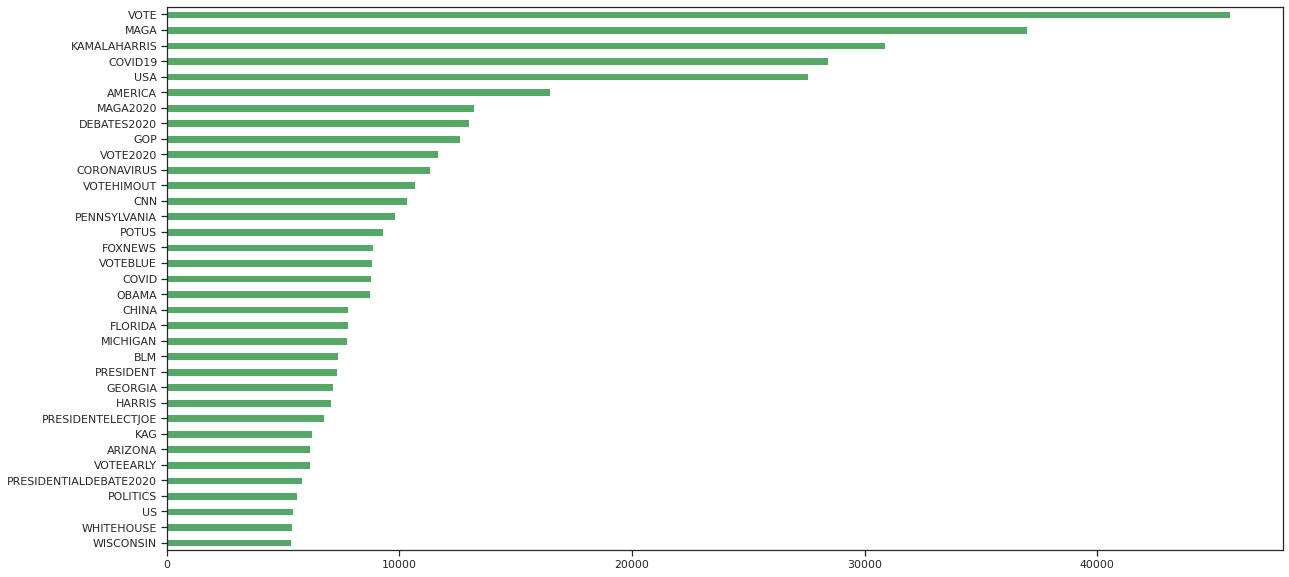

In [ ]:
# Removing some of the more obvious hashtags to reveal more hashtags
stophashtags = ["trump", "biden", "election2020", "donaldtrump","elections2020", "elections2020", "election", "ellecciones","elecciones", "republican", "democrat"]

filtered_hashtags = [tags for tags in allhashtags if (not any([x in tags.lower() for x in stophashtags]))]

pd.Series(filtered_hashtags).value_counts()[:35].sort_values(ascending=True).plot(kind="barh", color='g')

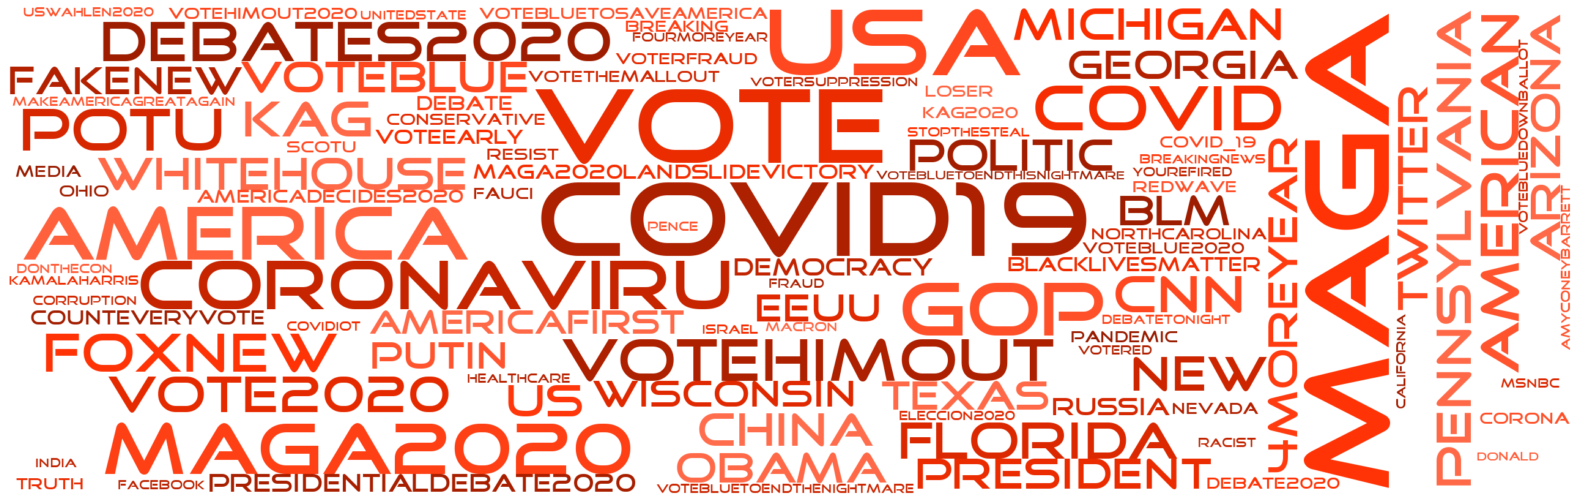

In [ ]:
trump_hashtags = get_hashtags(df_jd_concat[df_jd_concat.hashtag == "Trump"].copy())

# Filtering by Trump mentions
filtered_trump_hashtags = [tags for tags in trump_hashtags if (not any([x in tags.lower() for x in stophashtags]))]
text = " ".join(filtered_trump_hashtags)

# Creating wordcloud with the red colour function
wordcloud_create(text, random_red_colour )

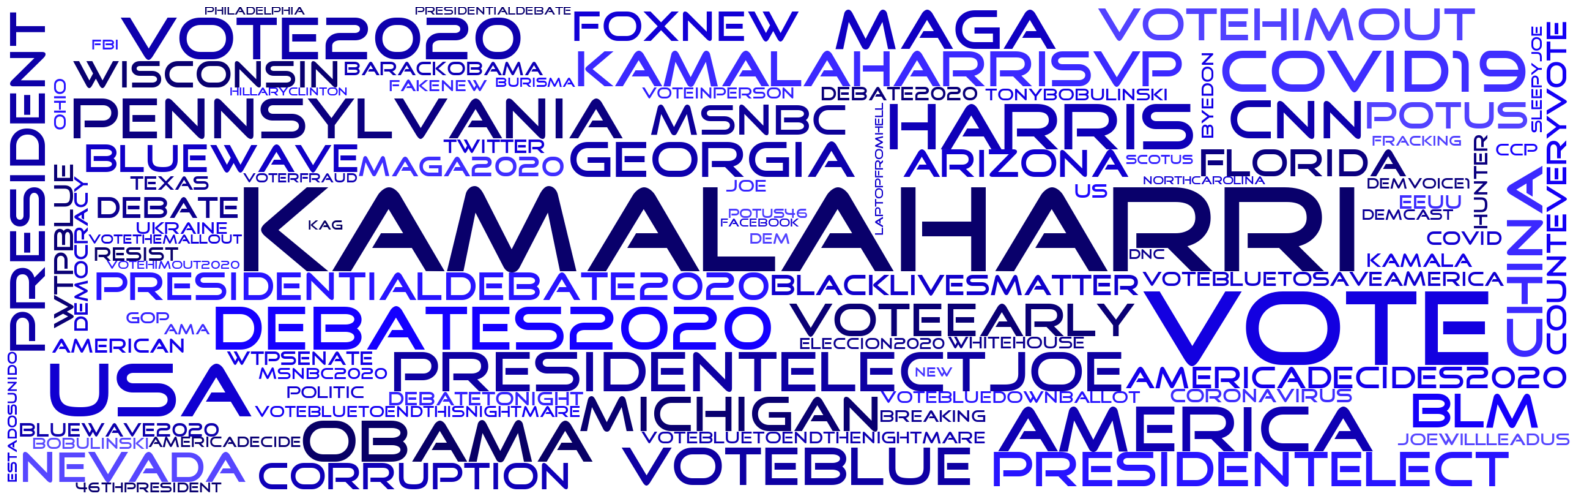

In [ ]:
biden_hashtags = get_hashtags(df_jd_concat[df_jd_concat.hashtag == "Biden"].copy())

# Filter Biden mentions 
filtered_biden_hashtags = [tags for tags in biden_hashtags if (not any([x in tags.lower() for x in stophashtags]))]
text = " ".join(filtered_biden_hashtags)

# Creating wordcloud with the blue colour function
wordcloud_create(text, random_blue_colour)

# Basic data cleaning

In [ ]:
# Drop null rows to increase processing time later on
print('Total size of Dataframe before removing NANs',df_jd_concat.shape)
df_jd_concat = df_jd_concat.dropna()
print('Total size After Removing NANs',df_jd_concat.shape)

Total size of Dataframe before removing NANs (1299223, 23)
Total size After Removing NANs (253655, 23)


In [ ]:
# Remove unnecessary columns for NLP Analysis dropping because the are not necessary for textual analysis
# All that is required for Natural language processing at a bare minimum; is the text field and a sentiment label

df_cols = df_jd_concat.drop(columns=['source','user_name','user_screen_name','user_description','user_join_date','collected_at'])

In [ ]:
#Remove other countries to capture only tweets originating from the US

df_usa = df_cols[df_cols.country == "United States of America"]

del df_cols

In [ ]:
#checking to see if the columns were removed
df_usa.shape

(143915, 17)

In [ ]:
#checking to see which columns remain
df_usa.dtypes

created_at              datetime64[ns]
tweet_id                       float64
tweet                           object
likes                          float64
retweet_count                  float64
user_id                        float64
user_followers_count           float64
user_location                   object
lat                            float64
long                           float64
city                            object
country                         object
continent                       object
state                           object
state_code                      object
hashtag                         object
all_hashtags                    object
dtype: object

In [ ]:
df_usa['hashtag'].value_counts()

Trump    77424
Biden    66491
Name: hashtag, dtype: int64

# Language Detection

In [ ]:
!pip install langdetect
import langdetect

     |████████████████████████████████| 983kB 15.2MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=c43608dffc963341703f32718aa12c656ec434a4eef20c155e7f933e6446efd7
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
# using an example text to test the lang detection
example_text = 'El Departamento de Comercio anunció que el formulario Censo 2020 no tendrá la pregunta de ciudadanía de Trump.'

In [ ]:
#try out TextBlob on a sample tweet
from textblob import TextBlob
b = TextBlob(example_text)
print(f'Language of text: \n{example_text}\nis: {b.detect_language()}')

Language of text: 
El Departamento de Comercio anunció que el formulario Censo 2020 no tendrá la pregunta de ciudadanía de Trump.
is: es


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
detect('El Departamento de Comercio anunció que el formulario Censo 2020 no tendrá la pregunta de ciudadanía de Trump.') 

'es'

In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

def get_language(tweet):
    try:                                                          
        lang=detect(tweet)                                      
    except:                                                       
        lang='no'
        
    return lang

In [ ]:
start_time = time.time()

test_df = df_usa.iloc[:1000].copy()
test_df['lang'] = test_df.tweet.apply(lambda x: get_language(x))

stop_time = time.time()
print(f'It took {np.around((time.time() - start_time),decimals=1)} seconds')

It took 8.6 seconds


In [ ]:
start_time = time.time()

df_usa['lang'] = df_usa.tweet.apply(lambda x: get_language(x))

stop_time = time.time()
print(f'It took {np.around((time.time() - start_time), decimals=1)} seconds')

It took 1303.7 seconds


In [ ]:
df_usa.to_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_usa.csv',index=False)

In [ ]:
df_usa = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_usa.csv')

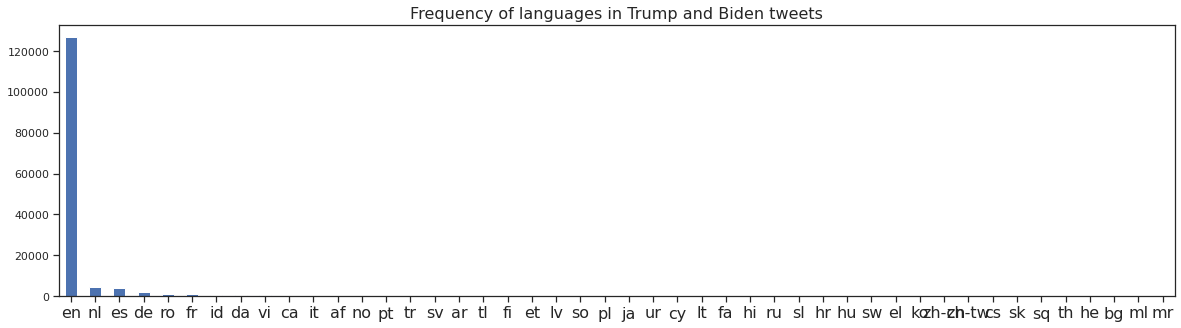

In [ ]:
plt.figure(figsize=(20,5))
ax = df_usa.lang.value_counts().plot.bar(rot=0)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.title('Frequency of languages in Trump and Biden tweets', fontsize=16)
plt.show()

In [ ]:
df_usa.shape

(143915, 18)

In [ ]:
df_en = df_usa[df_usa.lang == 'en']


In [ ]:
df_en.shape

(126532, 18)

# Lanuguage summary and visualizations

In [ ]:
df_en.dtypes

created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
user_id                 float64
user_followers_count    float64
user_location            object
lat                     float64
long                    float64
city                     object
country                  object
continent                object
state                    object
state_code               object
hashtag                  object
all_hashtags             object
lang                     object
dtype: object

In [ ]:
# For some reason the column type changed back to an object, so convert the created at colum to datetime
df_en['created_at'] =  pd.to_datetime(df_en['created_at'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_en.created_at.dtype

dtype('<M8[ns]')

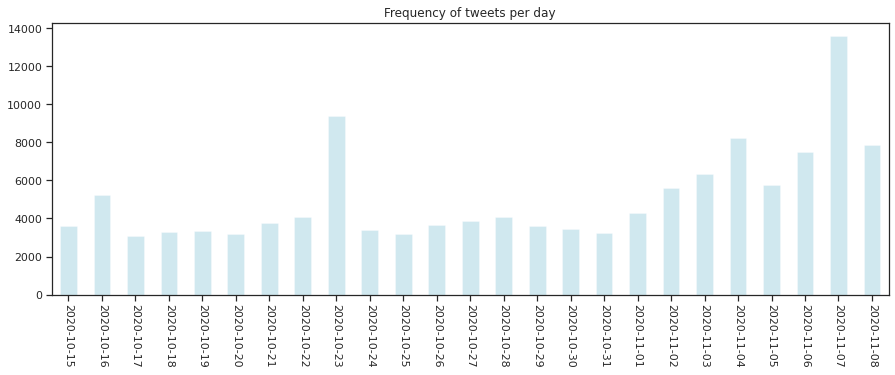

In [ ]:
plt.figure(figsize=(15,5))

df_en.created_at.dt.date.value_counts().sort_index().plot.bar(rot=270, alpha=0.3,color='c')

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.title('Frequency of tweets per day')
plt.show()

In [ ]:
most_popular_tweet = df_en.loc[df_en['retweet_count'].idxmax()]
print(f" The tweet:\n'{most_popular_tweet.tweet}'\nwas retweeted the most ({most_popular_tweet.retweet_count} times).")

 The tweet:
'Tonight a woman in the audience of Trump's town hall began her question by telling him he has a great smile &amp; he's so handsome when he smiles. And when #JoeBiden is President, hopefully that woman will be able to access better vision care, bless her heart.'
was retweeted the most (17652.0 times).


In [ ]:
df_en[['tweet_id','user_id','created_at', 'likes', 'retweet_count', 'tweet', 'hashtag']].iloc[df_en.retweet_count.sort_values(ascending=False).head(5).index]

,tweet_id,user_id,created_at,likes,retweet_count,tweet,hashtag
87686,1.318943e+18,5.445832e+06,2020-10-21 15:51:48,0.0,0.0,"I Voted! \n.\n.\nFollow @playarabbit \n.\n.\n.\n.\n#vote #playarabbit #blacklivesmatter #runwithmaud #barackobama #joebiden #fortworth #texas #hiphop #black @ Fort Worth, Texas https://t.co/iwfmwuOctL",Biden
113054,1.323380e+18,1.244982e+18,2020-11-02 21:40:35,3.0,1.0,"Click on joes picture it will take u to my page. There u will find over 25,000 more great memes, just click on retweet, Donald many as u can! #DemCast #wtpBlue #wtpBiden #BLM #MSNBC #Resist #BidenHarris #JoeBiden #JoeBidenKamalaHarris. #wtpsenate #voteblue #wtpBlue #DemVoice1 https://t.co/CvHJdexKic",Biden
124300,1.324533e+18,8.281490e+08,2020-11-06 02:02:44,1.0,0.0,"""This is your victory! It is the victory of the cause of freedom in every land."" -Winston Churchill, speech from VE Day.\n\nSeems apt #Freedom #2020Elections #JoeBiden",Biden
86995,1.318740e+18,1.482716e+07,2020-10-21 02:24:23,0.0,0.0,Conservatives after watching the #Biden #SamElliot ad... https://t.co/E4GpLcz4WZ https://t.co/CG6HykQx9T,Biden
31218,1.320834e+18,8.436472e+06,2020-10-26 21:04:19,1.0,1.0,#Trump gets distracted by a person in the crowd who is pointing at someone who is not him and demands to know who the person is pointing to. \n\nALL THE ATTENTION HAS TO BE ALL FOR DONNIE.,Trump


In [ ]:
df_en[df_en.tweet.str.contains('Are you there')][['created_at', 'tweet', 'user_id']]

,created_at,tweet,user_id
100971,2020-10-27 03:16:27,"Are you there, God? It's me, Bette. I'm so scared God. We have a fascist in the #WhiteHouse, a racist criminal who hates democracy, denies science &amp; kills our citizens! #ElectionDay is next week. What if he wins? We won't have a country! Please let #JoeBiden win. Thank you.",1.398238e+08
100975,2020-10-27 03:19:27,"Are you there, God? We have a fascist in the #WhiteHouse, a racist criminal who hates democracy, denies science &amp; kills our citizens! #ElectionDay is next week. What if he wins? We won't have a country! Please, please let #JoeBiden win. \nThank you.\nI love you @BetteMidler https://t.co/qubp3F7ZA1",2.366092e+09
110387,2020-11-01 20:41:36,"Are you there, God? It's me again, Bette. We're scared. We have a fascist in the #WhiteHouse, a racist criminal who hates democracy, denies science &amp; kills our citizens! #ElectionDay is in two days. What if he wins? We won't have a country! Please let #JoeBiden win. Thank you.",1.398238e+08


In [ ]:
print(f'There are {df_en.retweet_count.nunique()} different amounts of retweets')

There are 517 different amounts of retweets


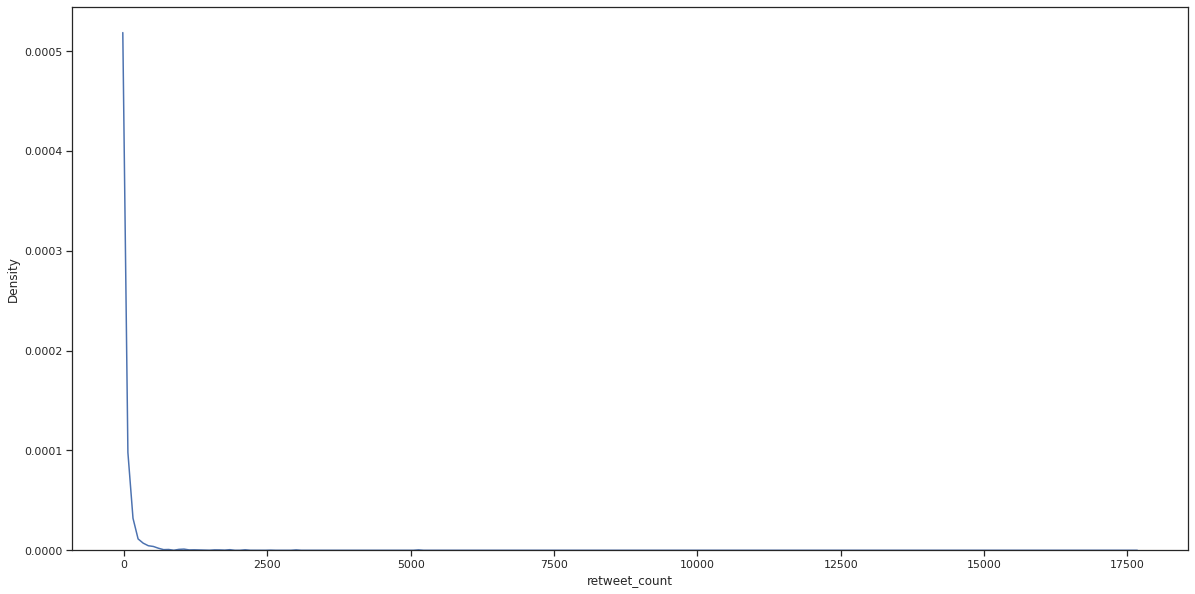

In [ ]:
sns.kdeplot(x='retweet_count', data=df_en)

In [ ]:
def get_wordnet_pos(word):
    ### Map POS tag to first character lemmatize() accepts ####
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(tweet, lemmatize = 'nltk'):

    tweet = tweet.lower() # lowercase
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE) # remove urls
    tweet = re.sub(r'\@\w+|\#','', tweet) # remove mentions of other usernames and the hashtag character
    tweet = remove_stopwords(tweet) # remove stopwords with Gensim

    if (lemmatize == 'spacy'):
        # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
        nlp = spacy.load('en', disable=['parser', 'ner'])
        doc = nlp(tweet)
        tokenized = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    elif (lemmatize == 'nltk'): 
        '''
        lemmatization works best when WordNetLemmatizer receives both the text and the part of speech of each word
        the code below assigns POS (part of speech) tag on a per word basis (it does not infer POS from contenxt / sentence), which might not be optimal
        '''
        lemmatizer = WordNetLemmatizer()
        tokenized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)]
    
    # remove left over stop words with nltk
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # remove non-alpha characters and keep the words of length >2 only
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]

    return tokenized

def combine_tokens(tokenized): 
    non_tokenized = ' '.join([w for w in tokenized])
    return non_tokenized

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
start =  time.time()

df_en['tokenized_tweet_nltk'] = df_en['tweet'].apply(lambda x: clean_text(x, 'nltk'))
df_en['clean_tweet_nltk'] = df_en['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))

stop = time.time()
print(f'Cleaning all tweets takes ~{round((stop-start)/60, 3)} minutes: ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Cleaning all tweets takes ~11.162 minutes: 


In [ ]:
df_clean = df_en
df_clean.to_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_clean.csv',index=False)

In [ ]:
df_clean = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_clean.csv', lineterminator='\n')

In [ ]:
df_clean.dtypes

created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
user_id                 float64
user_followers_count    float64
user_location            object
lat                     float64
long                    float64
city                     object
country                  object
continent                object
state                    object
state_code               object
hashtag                  object
all_hashtags             object
lang                     object
tokenized_tweet_nltk     object
clean_tweet_nltk         object
dtype: object

In [ ]:
# df_clean[df_clean.tweet_id.isin(list(df_don_trump.tweet_id))].hastag = 'trump'
# df_clean[df_clean.tweet_id.isin(list(df_joe_biden.tweet_id))].hastag = 'biden'

In [ ]:
df_clean.head(10)[['tweet', 'clean_tweet_nltk']]

,tweet,clean_tweet_nltk
0,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",trump student hear year year heard china know ask say know million like million
1,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,tie tie trump rally iowa
2,#Trump #PresidentTrump #Trump2020LandslideVictory #Trump2020 #MAGA #KAG #4MoreYears #America #AmericaFirst #AllLivesMatter #Winning #Vote #VoteInPerson #VoteTrump #VotePresidentTrump https://t.co/TzXBKOvgNs,trump presidenttrump maga kag america americafirst alllivesmatter win vote voteinperson votetrump votepresidenttrump
3,"#Trump: Nobody likes to tell you this, but some of the farmers were doing better the way I was doing it than they were by working their asses off.\n\nAnd that check? It's totally in the mail, right Don?",trump like tell farmer well way work ass check totally mail right
4,@karatblood @KazePlays_JC Grab @realDonaldTrump by the balls &amp; chuck the bastard out the door onto #PennsylvaniaAvenue &amp; form a line &amp; everybody gets to kick #DonaldTrump in the nuts! Please note 1 kick per person only! #BidenHarrisToSaveAmerica #VoteBlueToSaveOurDemocracy,grab ball amp chuck bastard door pennsylvaniaavenue amp form line amp everybody get kick donaldtrump nut note kick person bidenharristosaveamerica votebluetosaveourdemocracy
5,Who does #trump owe 420 million dollars to? What are the terms? Who is #DonaldTrump beholden to? WE DEMAND TO KNOW!\n#TrumpIsANationalSecurityRisk \n#FollowTheMoney \n#TrumpTaxCheat \n#TrumpTaxFraud,trump owe million dollar term donaldtrump beholden demand know trumpisanationalsecurityrisk followthemoney trumptaxcheat trumptaxfraud
6,"#TheWeek: ""#Trump in Penn: ""I saved suburbia. I got rid of a regulation that was a disaster and it was really unfair and it's gotten a lot worse under Obama and Biden. You damn well better vote for me Pennsylvania, you better vote."" But he never did identify the 'regulation.' https://t.co/7CX0PBJ2hA",theweek trump penn save suburbia get rid regulation disaster unfair gotten lot bad obama biden damn well vote pennsylvania well vote identify
7,#TheReidOut \n\nAm I suppose to feel badly for @OMAROSA? Isn't she the person who once claimed #Trump critics would have to bow at the feet of Donald? Sorry the snakes deserve one another. \n\n@JoyAnnReid,thereidout suppose feel badly person claimed trump critic bow foot donald sorry snake deserve another
8,I have lost track of what #Trump is talking about. So has Trump.,lose track trump talk trump
9,@glennkirschner2 So basically the American experiment has failed ; we have no power we are just at the mercy to theses people .. not just Trump but the people who are down for his agenda ; because let’s not pretend #Trump hasn’t done anything that the isn’t on the GOP’s wish list ..,basically american experiment fail power mercy thesis people trump people agenda let pretend trump gop wish list


In [ ]:
#Splitting the dataset to make the graphing analysis easier below

df_don2 = df_clean[df_clean['hashtag']=='Trump']
df_joe2 = df_clean[df_clean['hashtag']=='Biden']

In [ ]:
print(df_clean['hashtag'].value_counts())
print(df_don2['hashtag'].value_counts())
print(df_joe2['hashtag'].value_counts())

Trump    71002
Biden    55530
Name: hashtag, dtype: int64
Trump    71002
Name: hashtag, dtype: int64
Biden    55530
Name: hashtag, dtype: int64


# Text blob

In [ ]:
df_clean['clean_tweet_nltk'].astype(str)


In [ ]:
def create_sentiment_labels(df, feature,value):
    '''
    in: 
        dataframe 
        value on which to classify
        feature - column name of the feature that receives the label
    out: 
        does not return a value
        modifies the dataframe received as parameter
    '''

    df.loc[df[value] > 0,feature] = 'positive'
    df.loc[df[value] == 0,feature] = 'neutral'
    df.loc[df[value] < 0,feature] = 'negative'

In [ ]:
# Polarity and subjectivity
def sentiment_analysis(dataframe):
    dataframe['blob_polarity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.polarity)
    dataframe['blob_subjectivity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    create_sentiment_labels(dataframe, 'blob_sentiment','blob_polarity')
    
    return dataframe[['clean_tweet_nltk','blob_polarity','blob_subjectivity','blob_sentiment']].head()   

In [ ]:
start =  time.time()

sentiment_analysis(df_clean)

stop = time.time()
print(f'Sentiment analysis with TextBlob took: {round((stop-start)/60, 3)} minutes')

TypeError: ignored

In [ ]:
df_concat_tweets.head(10)[['blob_polarity','blob_subjectivity', 'blob_sentiment']]

In [ ]:
#update the divided dataset
df_don_trump = df_concat_tweets[df_concat_tweets.ds=='trump']
df_joe_biden = df_concat_tweets[df_concat_tweets.ds=='biden']

fig, axes = plt.subplots(1, 2, figsize=(8,5))

fig.suptitle('TextBlob analysis: nmean polarity (-1.0, 1.0) and mean subjectivity (0.0, 1.0) per candidate (one tweet, one sentiment)', fontsize=14)

features = ['blob_polarity', 'blob_subjectivity']
values = [df_don_trump.groupby(['user_id'])['blob_polarity'].mean().mean(), df_don_trump.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 12)

values = [df_joe_biden.groupby(['user_id'])['blob_polarity'].mean().mean(), df_joe_biden.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 12)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

trump_usa_pol_tweet =df_don_trump['blob_polarity'].mean()
trump_usa_subj_tweet = df_don_trump['blob_subjectivity'].mean()
biden_usa_pol_tweet = df_joe_biden['blob_polarity'].mean()
biden_usa_subj_tweet = df_joe_biden['blob_subjectivity'].mean()

In [ ]:
# the below gives us a mean per user
# df_don_trump_usa[['user_id', 'Polarity']].groupby(['user_id'])['Polarity'].mean()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle('TextBlob analysis: mean polarity (-1.0, 1.0) and mean subjectivity (0.0, 1.0)\nper candidate (one user, one sentiment)', fontsize=14)

features = ['blob_polarity', 'blob_subjectivity']
values = [df_don_trump.groupby(['user_id'])['blob_polarity'].mean().mean(), df_don_trump.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2,)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 12)

values = [df_joe_biden.groupby(['user_id'])['blob_polarity'].mean().mean(), df_joe_biden.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2,)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 12)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

trump_usa_pol_user = df_don_trump.groupby(['user_id'])['blob_polarity'].mean().mean()
trump_usa_subj_user = df_don_trump.groupby(['user_id'])['blob_subjectivity'].mean().mean()
biden_usa_pol_user = df_joe_biden.groupby(['user_id'])['blob_polarity'].mean().mean()
biden_usa_subj_user = df_joe_biden.groupby(['user_id'])['blob_subjectivity'].mean().mean()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

fig.suptitle('TextBlob analysis: \nmean polarity and mean subjectivity\n (tweet level = one tweet, one sentiment) vs (user level = one user, one sentiment)', fontsize=16)

#features = ['Polarity', 'Subjectivity']
features = np.array([1, 2])
values_tweet = [ trump_usa_pol_tweet, trump_usa_subj_tweet]
values_user = [ trump_usa_pol_user, trump_usa_subj_user]

#values = [[trump_usa_pol_tweet, trump_usa_subj_tweet], 
#[trump_usa_pol_user, trump_usa_subj_user]]

axes[0].bar(features-0.2, values_tweet, width=0.2, align = 'center', color = 'y')
axes[0].bar(features, values_user, width=0.2, align = 'center', color = 'g')
#axes[0].bar(features,values)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Average value', fontsize = 14)
axes[0].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])
labels= ["tweet level", "user level"]
axes[0].legend(labels)

values_tweet = [ biden_usa_pol_tweet, biden_usa_subj_tweet]
values_user = [ biden_usa_pol_user, biden_usa_subj_user]
axes[1].bar(features-0.2,values_tweet, width=0.2, align = 'center', color = 'y')
axes[1].bar(features,values_user, width=0.2, align = 'center', color = 'g')
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Average value', fontsize = 14)
axes[1].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])

labels= ["tweet level", "user level"]
axes[1].legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

In [ ]:
plt.figure(figsize=(6,5))

ax = plt.gca()
ax.set_title('--Relative--\nTextBlob sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)

features = np.array([1,2,3])
trump = (df_don_trump['blob_sentiment'].sort_values().value_counts()/df_don_trump['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']]
ax.bar(features-0.3, trump.values, width=0.3, align = 'center', color = 'r', alpha= .6)

biden = (df_joe_biden['blob_sentiment'].sort_values().value_counts()/df_joe_biden['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']]
ax.bar(features, biden.values, width=0.3, align = 'center', color = 'b', alpha= .6)

ax.set_ylim(0, .5)
ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('Relative frequency', fontsize = 14)

ax.set_xticklabels(['', '', 'Negative', '', 'Neutral', '', 'Positive'])

labels= ["Trump", "Biden"]
ax.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

# Vader

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analysis_vader(df, clean = True):
    if clean:
        target_col = 'clean_tweet_nltk'
        prefix = 'vader_clean_'
    else:
        target_col = 'tweet'
        prefix = 'vader_'
    
    scores_col = prefix+'scores'
    
    #let's make it vader_sentiment, so that it has the same naming convention as TextBlob and Flair sentiment score
    #compound_col = prefix+'compound'
    compound_col = prefix+'polarity'
    
    #comp_score_col = prefix+'comp_score'
    comp_score_col = prefix+'sentiment' 
    
    df[scores_col] = df[target_col].apply(lambda tweet: sid.polarity_scores(tweet))
    df[compound_col] = df[scores_col].apply(lambda d: d['compound'])
    create_sentiment_labels(df,comp_score_col,compound_col)

In [ ]:
start = time.time()

sentiment_analysis_vader(df_concat_tweets)
sentiment_analysis_vader(df_concat_tweets, clean = False)

stop = time.time()
print(f'Sentiment analysis with VADER took: {round((stop-start)/60, 3)} minutes')

#update the divided dataset
df_don_trump = df_concat_tweets[df_concat_tweets.ds=='trump']
df_joe_biden = df_concat_tweets[df_concat_tweets.ds=='biden']

Sentiment analysis with VADER took: 1.062 minutes


In [ ]:
from sklearn.metrics import accuracy_score

start = time.time()

print(f"Accuracy score for our cleaning vs vader tweet cleaning for Trump: {accuracy_score(df_don_trump['vader_sentiment'],df_don_trump['vader_clean_sentiment']):.4}")
print(f"Accuracy score for our cleaning vs vader tweet cleaning for Biden: {accuracy_score(df_joe_biden['vader_sentiment'],df_joe_biden['vader_clean_sentiment']):.4}")

stop = time.time()
print(f'This took: {round((stop-start)/60, 3)} minutes')

Accuracy score for our cleaning vs vader tweet cleaning for Trump: 0.8401
Accuracy score for our cleaning vs vader tweet cleaning for Biden: 0.877
This took: 0.003 minutes


In [ ]:
#Uncomment the code below if you want to visualize some tweets yourself
#We decided based on analysis to feed the raw tweet to VADER and let it run the cleaning itself

#Some tweets arel long. This setting makes sure Python does not truncate the output. Default value is 50.

pd.options.display.max_colwidth = 300
df_don_trump[['tweet', 'clean_tweet_nltk', 'vader_sentiment', 'vader_clean_sentiment']].head(20)

,tweet,clean_tweet_nltk,vader_sentiment,vader_clean_sentiment
58876,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",trump student hear year year heard china know ask say know million like million,positive,positive
58877,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,tie tie trump rally iowa,neutral,neutral
58878,#Trump #PresidentTrump #Trump2020LandslideVictory #Trump2020 #MAGA #KAG #4MoreYears #America #AmericaFirst #AllLivesMatter #Winning #Vote #VoteInPerson #VoteTrump #VotePresidentTrump https://t.co/TzXBKOvgNs,trump presidenttrump maga kag america americafirst alllivesmatter win vote voteinperson votetrump votepresidenttrump,neutral,positive
58879,"#Trump: Nobody likes to tell you this, but some of the farmers were doing better the way I was doing it than they were by working their asses off.\n\nAnd that check? It's totally in the mail, right Don?",trump like tell farmer well way work ass check totally mail right,positive,positive
58880,@karatblood @KazePlays_JC Grab @realDonaldTrump by the balls &amp; chuck the bastard out the door onto #PennsylvaniaAvenue &amp; form a line &amp; everybody gets to kick #DonaldTrump in the nuts! Please note 1 kick per person only! #BidenHarrisToSaveAmerica #VoteBlueToSaveOurDemocracy,grab ball amp chuck bastard door pennsylvaniaavenue amp form line amp everybody get kick donaldtrump nut note kick person bidenharristosaveamerica votebluetosaveourdemocracy,negative,negative
58881,Who does #trump owe 420 million dollars to? What are the terms? Who is #DonaldTrump beholden to? WE DEMAND TO KNOW!\n#TrumpIsANationalSecurityRisk \n#FollowTheMoney \n#TrumpTaxCheat \n#TrumpTaxFraud,trump owe million dollar term donaldtrump beholden demand know trumpisanationalsecurityrisk followthemoney trumptaxcheat trumptaxfraud,negative,negative
58882,"#TheWeek: ""#Trump in Penn: ""I saved suburbia. I got rid of a regulation that was a disaster and it was really unfair and it's gotten a lot worse under Obama and Biden. You damn well better vote for me Pennsylvania, you better vote."" But he never did identify the 'regulation.' https://t.co/7CX0PB...",theweek trump penn save suburbia get rid regulation disaster unfair gotten lot bad obama biden damn well vote pennsylvania well vote identify,negative,negative
58883,#TheReidOut \n\nAm I suppose to feel badly for @OMAROSA? Isn't she the person who once claimed #Trump critics would have to bow at the feet of Donald? Sorry the snakes deserve one another. \n\n@JoyAnnReid,thereidout suppose feel badly person claimed trump critic bow foot donald sorry snake deserve another,negative,negative
58884,I have lost track of what #Trump is talking about. So has Trump.,lose track trump talk trump,negative,negative
58885,@glennkirschner2 So basically the American experiment has failed ; we have no power we are just at the mercy to theses people .. not just Trump but the people who are down for his agenda ; because let’s not pretend #Trump hasn’t done anything that the isn’t on the GOP’s wish list ..,basically american experiment fail power mercy thesis people trump people agenda let pretend trump gop wish list,positive,positive


In [ ]:
def get_valence_relative_freq(df):
    #grouped = df.sort_values('comp_score').groupby(['comp_score'], sort=False)
    grouped = df.sort_values('vader_sentiment').groupby(['vader_sentiment'], sort=False)
    valence = grouped['vader_sentiment'].value_counts(normalize=False, sort=False)
    valence = valence.droplevel(0)
    valence = valence / valence.sum()
    return valence

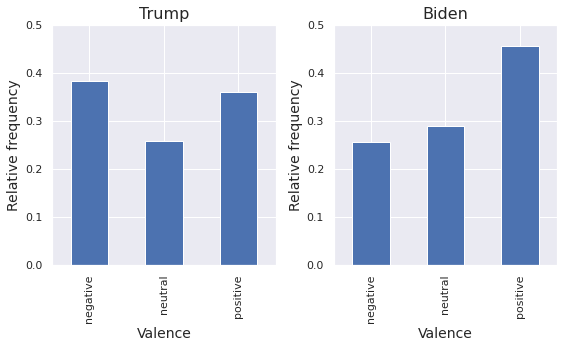

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

trump_tmp = get_valence_relative_freq(df_don_trump)
biden_tmp = get_valence_relative_freq(df_joe_biden)

# plt.figure(figsize=(8,6))
fig, axes = plt.subplots(1, 2, figsize=(8,5))
# fig.suptitle('Vader sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)
# fig.tight_layout()

# sns.barplot(trump_tmp.index, trump_tmp.values, ax=axes[0])
(trump_tmp).plot(kind='bar', ax = axes[0])
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Valence', fontsize = 14)
axes[0].set_ylabel('Relative frequency', fontsize = 14)
axes[0].set_ylim(0, .5)

# ax2 = sns.countplot(x="comp_score", data=biden_tmp)
# sns.barplot(biden_tmp.index, biden_tmp.values,  ax=axes[1])
(biden_tmp).plot(kind='bar', ax = axes[1])
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Valence', fontsize = 14)
axes[1].set_ylabel('Relative frequency', fontsize = 14)
axes[1].set_ylim(0, .5)

plt.tight_layout()
plt.show()

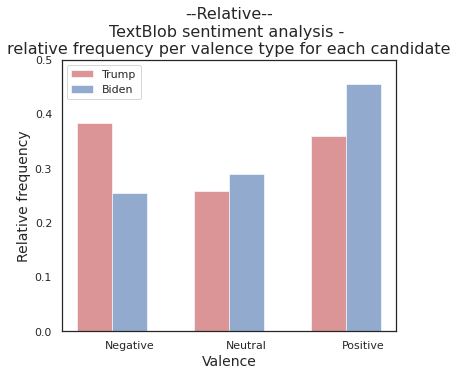

In [ ]:
plt.figure(figsize=(6,5))
sns.set_style("white")

ax = plt.gca()
ax.set_title('--Relative--\nTextBlob sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)

features = np.array([1,2,3])

trump = get_valence_relative_freq(df_don_trump)
ax.bar(features-0.3, trump.values, width=0.3, align = 'center', color = 'r', alpha= .6)

biden = get_valence_relative_freq(df_joe_biden)
ax.bar(features, biden.values, width=0.3, align = 'center', color = 'b', alpha= .6)

ax.set_ylim(0, .5)
ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('Relative frequency', fontsize = 14)

ax.set_xticklabels(['', '', 'Negative', '', 'Neutral', '', 'Positive'])

labels= ["Trump", "Biden"]
ax.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

In [ ]:
print(df_don_trump['vader_polarity'].mean())
print(df_joe_biden['vader_polarity'].mean())

sns.set_theme(style="darkgrid")

fig = plt.figure(figsize=(6,6))

fig.suptitle('Mean VADER compound score (between -1.0 and 1.0)\nfor Trump and Biden', fontsize=16)

features = ['Mean Valence Trump', 'Mean Valence Biden']
values = [df_don_trump['vader_polarity'].mean(), df_joe_biden['vader_polarity'].mean()]

plt.bar(features,values, width=0.2)

axes = plt.gca()
axes.set_ylim(-.3, .3)
axes.set_xlabel('Feature', fontsize = 14)
axes.set_ylabel('Value', fontsize = 14)

plt.show()

KeyError: ignored

In [ ]:
sns.set_theme(style='ticks')

bins = 50

fig = plt.figure(figsize=(8,5))
fig.suptitle('Histograms of tweets polarity per candidate (VADER)', fontsize=16)

plt.hist(df_don_trump['vader_polarity'], bins = bins, alpha = 0.5, color = 'r')
plt.hist(df_joe_biden['vader_polarity'], bins = bins, alpha = 0.5, color = 'b')

axes = plt.gca()
axes.set_ylim(0, 2500)

labels= ["Trump", "J.Biden"]
axes.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

In [ ]:
bins = 50

fig = plt.figure(figsize=(8,5))
fig.suptitle('Histograms of tweets polarity per candidate (VADER)', fontsize=16)

plt.hist(df_don_trump['vader_polarity'], bins = bins, alpha = 0.5, color = 'r')
plt.hist(df_joe_biden['vader_polarity'], bins = bins, alpha = 0.5, color = 'b')

axes = plt.gca()
axes.set_ylim(0, 30000)

labels= ["Trump", "J.Biden"]
axes.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

In [ ]:
classifier = TextClassifier.load('en-sentiment')

2021-04-03 21:52:49,402 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpv7jr3w_j


100%|██████████| 265512723/265512723 [00:16<00:00, 16450461.12B/s]

2021-04-03 21:53:06,039 copying /tmp/tmpv7jr3w_j to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-04-03 21:53:06,683 removing temp file /tmp/tmpv7jr3w_j
2021-04-03 21:53:06,714 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


# Flair

In [ ]:
!pip install flair
from flair.models import TextClassifier #pre-trained sentiment analyzer
from flair.data import Sentence
from segtok.segmenter import split_single

In [ ]:
sentence = Sentence('Trump is the best president ever!')
classifier.predict(sentence)

print('The resulting sentiment from the sentence above is: ', sentence.labels)

The resulting sentiment above is:  [POSITIVE (0.9921)]


In [ ]:
def flair_make_sentences(text):
    """ Break apart text into a list of sentences """
    sentences = [sent for sent in split_single(text)]
    return sentences

def flair_predict_sentences(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['labels'][0]['confidence']
    else:
        result = -(text.to_dict()['labels'][0]['confidence'])
    return round(result, 3)

def flair_get_scores_per_sentences(sentences):
    """ Call predict on every sentence of a text """
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(flair_predict_sentences(sentences[i]))
    results.append(flair_predict_sentences(sentences[0]))
    return results

def flair_get_sum(scores):
    result = round(sum(scores), 3)
    return result

def flair_get_avg_from_sentences(scores):
    result = round(np.mean(scores), 3)
    return result

def flair_get_score_tweet(text):
  if not text:
    return 0
  s = Sentence(text)
  classifier.predict(s)
  value = s.labels[0].to_dict()['value'] 
  if value == 'POSITIVE':
    result = s.to_dict()['labels'][0]['confidence']
  else:
    result = -(s.to_dict()['labels'][0]['confidence'])
  return round(result, 3)

def sentiment_analysis_flair(polarity):
  if polarity > 0:
    return 'positive'
  if polarity == 0:
    return 'neutral'
  if polarity < 0:
    return 'positive'

In [ ]:
records = 1000
temp = df_concat_tweets[df_concat_tweets.ds=='trump'][:records].copy()

start = time.time()

#flair sentiment by diving tweet into sentences and averaging
temp['sentences'] = temp['clean_tweet_nltk'].apply(flair_make_sentences)
temp['scores'] = temp['sentences'].apply(flair_get_scores_per_sentences)
temp['flair_scores_avg'] = temp.scores.apply(flair_get_avg_from_sentences)

#flair sentiment on the whole tweet
temp['flair_one_score'] = temp['clean_tweet_nltk'].apply(flair_get_score_tweet)

stop = time.time()
print(round((stop-start)/60, 3))

3.29


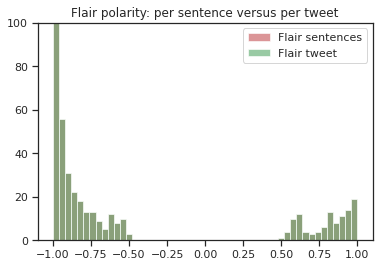

In [ ]:
bins = 50
alpha = 0.6
fig = plt.plot(figsize=(6,5))

plt.title('Flair polarity: per sentence versus per tweet')
ax = plt.gca()

ax.hist(temp['flair_scores_avg'], bins = bins, alpha = alpha, color = 'r')
ax.hist(temp['flair_one_score'], bins = bins, alpha = alpha, color = 'g')

ax.set_ylim(0, 100)
labels= ["Flair sentences", "Flair tweet"]
ax.legend(labels)
plt.show()

In [ ]:
temp['flair_sentiment'] = temp['flair_one_score'].apply(sentiment_analysis_flair)

# Comparison of all 3

In [ ]:
print(f"Agreement between TextBlob - VADER: {accuracy_score(temp['blob_sentiment'],temp['vader_sentiment']):.4}")
print(f"Agreement between TextBlob - Flair: {accuracy_score(temp['blob_sentiment'],temp['flair_sentiment']):.4}")
print(f"Agreement between VADER - Flair: {accuracy_score(temp['vader_sentiment'],temp['flair_sentiment']):.4}")

Agreement between TextBlob - VADER: 0.532
Agreement between TextBlob - Flair: 0.31
Agreement between VADER - Flair: 0.379


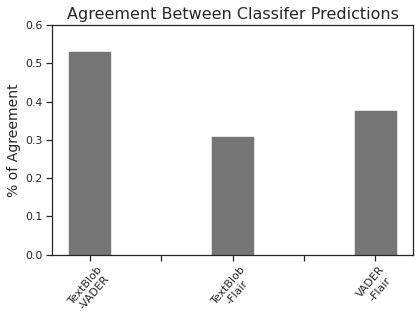

In [ ]:
fig = plt.figure(figsize=(6,6))

ax = plt.gca()
ax.set_title('Agreement Between Classifer Predictions', fontsize=16)

features = np.array([1,2,3])
values = [accuracy_score(temp['blob_sentiment'],temp['vader_sentiment']), accuracy_score(temp['blob_sentiment'],temp['flair_sentiment']), accuracy_score(temp['vader_sentiment'],temp['flair_sentiment'])]

ax.bar(features, values, width=0.3, align = 'center', color = 'k', alpha= .6)

ax.set_ylim(0, .6)
#ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('% of Agreement', fontsize = 14)

ax.set_xticklabels(['', 'TextBlob\n-VADER', '', 'TextBlob\n-Flair', '', 'VADER\n-Flair'], rotation=50)


fig.tight_layout(rect=[0, 0.03, 1, 0.80])
plt.show()

In [ ]:
def consensus(row):
    count = 0
    count += row['blob_sentiment']==row['vader_sentiment']
    count += row['blob_sentiment']==row['flair_sentiment']
    count += row['vader_sentiment']==row['flair_sentiment']

    return count

temp['consensus'] = temp.apply(lambda row: consensus(row), axis=1)

print(temp['consensus'].value_counts())

1    681
3    180
0    139
Name: consensus, dtype: int64


In [ ]:
# Change the number of displayd results in the code below if you want to visually inspect more of them yourself
(temp[temp['consensus']==0])[['tweet', 'clean_tweet_nltk', 'blob_sentiment', 'vader_sentiment', 'flair_sentiment']].tail(10)

,tweet,clean_tweet_nltk,blob_sentiment,vader_sentiment,flair_sentiment
59821,"@KingAlsacian @owtaspAs @lurkingwolf45 @MarkDice ...actually, the “WORLD” wouldn’t mind #Trump in prison either!",actually world mind trump prison either,neutral,negative,positive
59827,.-.\nWTH YOU HAVE TO LOSE?!\n\n#DonaldTrump is attacking #FakeNews\nPissed off from lackluster reviews\n.he thinks he’s enchanting\n.while raving &amp; ranting\n&amp; shouting WHAT DO U HAVE TO LOSE!!!\n\n #TraitorTrump #traitorgop\n#Election2020\n#BidenHarrisToSaveAmerica\n\nhttps://t.co/rLMNbJ...,wth lose donaldtrump attack fakenews piss lackluster review think enchant rave amp rant amp shout lose traitortrump traitorgop bidenharristosaveamerica,neutral,negative,positive
59829,In Case Anybody Is Still Unclear On Fact That Giuliani Is As Big A Racist A**hole As #Trump Is . #Vote2020 #VoteOutRacism #VoteOutHate #VoteOutTrump\nhttps://t.co/PR09j0too1 via @thedailybeast,case anybody unclear fact giuliani big racist trump voteoutracism voteouthate voteouttrump,neutral,negative,positive
59831,".-.\nPEACOCKY BETRAYAL\n\nTonight some will watch #Trump distract\nAnd create an alternative fact\n..but #NBC’s depraved\n..cuz when asked, they caved\nAnd betrayed their #Fairness contract. \n\n#TrumpIsALoser #NBCIsTrumpsAccomplice #NBCBlackout #TraitorInChief \n\nhttps://t.co/RazaFjhImr",peacocky betrayal tonight watch trump distract create alternative fact nbc deprave ask cave betrayed fairness contract trumpisaloser nbcistrumpsaccomplice nbcblackout traitorinchief,neutral,negative,positive
59833,"Is America not being ""double crossed"" &amp; deceived when POTUS wants #AmyConeyBarrett on #SCOTUS for her opposition to #Obamacare #RoeVsWade #VotingRights but Judge says that she doesn't know why #DonaldTrump nominated her. #SCOTUSHearing #SenateJudiciaryCommittee #FoxNews #CNN https://t.co/vC6...",america double cross amp deceive potus want amyconeybarrett scotus opposition obamacare roevswade votingrights judge say know donaldtrump nominate scotushearing senatejudiciarycommittee foxnews cnn,neutral,negative,positive
59838,@thinkingtime55 I really believe it is too close and I’m worried that we will lose to a cheating #Trump. GET OUT AND VOTE!!! GIVE BIDEN A GIANT🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊VICTORY!!,believe close worried lose cheat trump vote biden,neutral,negative,positive
59848,So @SHO_Dexter came back to take @realDonaldTrump and @JoeBiden out the game right? \n\n#DexterReturns #Dexter #Dexter10 #trump #BidenCrimeFamily #ChickenTrump,come game right dexterreturns dexter trump bidencrimefamily chickentrump,negative,neutral,positive
59865,Check out my latest cartoon on @TinyviewComics! #HerdMentality #HerdImmunity #Trump #SocialDistancing #MaskUp https://t.co/tVPg8z7vO2,check late cartoon herdmentality herdimmunity trump socialdistancing maskup,negative,neutral,positive
59874,@fox32news #Trump disciples killing police was not on my hellscape bingo card.,trump disciple kill police hellscape bingo card,neutral,negative,positive
59875,"It’s just 19 days until #Election2020 Plenty to discuss with @MLRoberts360 on #TheAmericanChronicle including voter enthusiasm, Republican targeting of white, male, non-college or educated first time voters, and how fear of #woke policies could lead to a second term for #Trump",day plenty discus theamericanchronicle include voter enthusiasm republican target white male educate time voter fear woke policy lead second term trump,neutral,negative,positive


# Insights

In [ ]:
rel_senti = df_concat_tweets[['state','vader_clean_polarity','ds']].groupby(['state','ds']).mean()
rel_senti.reset_index(inplace = True)

In [ ]:
rel_senti

,state,ds,vader_clean_polarity
0,Alabama,biden,0.116889
1,Alabama,trump,-0.010295
2,Alaska,biden,0.162138
3,Alaska,trump,-0.064447
4,Arizona,biden,0.101238
5,Arizona,trump,-0.018416


In [ ]:
# checking to see if all 52 States per candidate are present; there should be a total of a 104
rel_senti.shape

(103, 3)

There is only a total of a 103 States which indicates that one State is missing; i.e. no one tweeted about the candidate from that State

In [ ]:
total_test = (rel_senti.state.value_counts()!=2).reset_index()
total_test[total_test.state == True]

,index,state
51,South Dakota,True


In [ ]:
rel_senti[rel_senti.state=='South Dakota']

,state,ds,vader_clean_polarity
84,South Dakota,biden,0.15873


In [ ]:
rel_senti = rel_senti.append({'state': 'South Dakota', 'ds':'trump', 'vader_clean_polarity':0}, ignore_index=True)
rel_senti.sort_values('state', ascending=True, inplace=True)
rel_senti.reset_index(drop=True)

,state,ds,vader_clean_polarity
0,Alabama,biden,0.116889
1,Alabama,trump,-0.010295
2,Alaska,biden,0.162138
3,Alaska,trump,-0.064447
4,Arizona,biden,0.101238
...,...,...,...
99,West Virginia,trump,-0.055240
100,Wisconsin,biden,0.167222
101,Wisconsin,trump,-0.019822
102,Wyoming,biden,0.038167


In [ ]:
rel_senti = rel_senti[['state','vader_clean_polarity']].groupby('state')
rel_senti = rel_senti.diff(periods=-1)

In [ ]:
rel_senti.dropna(inplace=True)
rel_senti.reset_index(inplace = True, drop=True)
rel_senti.head(4)

,vader_clean_polarity
0,0.127184
1,0.226585
2,0.119655
3,0.331824


In [ ]:
states_df = pd.DataFrame(data=np.sort(df_concat_tweets.state.unique()), columns=['state'])
rel_senti = rel_senti.join(states_df)
rel_senti.head(3)

,vader_clean_polarity,state
0,0.127184,Alabama
1,0.226585,Alaska
2,0.119655,Arizona


# Mapping

In [ ]:
geo_usa_df = pd.read_json('../input/a-simple-geojson-file-for-us-state/geo_usa.json')
geo_usa_df.head()